In [7]:
import os
import random
import time
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors
import numpy as np

## Reference
Li, Chen, et al. "Mux-Kmeans: Multiplex Kmeans for Clustering Large-Scale Data Set." *Proceedings of the 5th ACM Workshop on Scientific Cloud Computing (ScienceCloud'14)*, 23–27 June 2014, Vancouver, BC, Canada, ACM, 2014, pp. 1-7. https://doi.org/10.1145/2608029.2608033

## Adaptation
1. The algorithm was converted from map-reduce to spark
2. The algorithm was adapted to parallelize all the heavy computations including the cluster assignment and twcv
3. The TWCV is calculated in parallel utilizing the rdd

# TWCV Calculation Function

### What is TWCV?
The **Total Within-Cluster Variation (TWCV)** is a measure of the clustering quality. It calculates the sum of squared Euclidean distances between each data point and the centroid of its assigned cluster. A lower TWCV indicates better clustering as the points are closer to their respective centroids.

### Formula
$$
\text{TWCV} = \sum_{j=1}^K \sum_{x_i \in C_j} \| x_i - c_j \|^2
$$
Where:
- $( K )$: Number of clusters.
- $( C_j)$: Set of data points assigned to the $j$-th cluster.
- $( x_i)$: Data point in cluster $( C_j )$.
- $( c_j)$: Centroid of the $( j )$-th cluster.
- $( | x_i - c_j |^2 )$: Squared Euclidean distance between the data point $( x_i )$ and the centroid $( c_j $).

In [2]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("Mux-Kmeans") \
    .master("spark://spark-master:7077") \
    .getOrCreate()

sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/17 19:14:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
A3_DATASET_URL = "https://cs.joensuu.fi/sipu/datasets/a3.txt"
DATA_FOLDER = "/home/jovyan/work/data"
A3_LOCAL_PATH = os.path.join(DATA_FOLDER, "a3.txt")

k = 50  # Number of clusters
s = 10  # Number of centroid groups
max_iterations = 20
num_partitions = 10


# Download Data
if not os.path.exists(A3_LOCAL_PATH):
    with open(A3_LOCAL_PATH, 'wb') as file:
        response = requests.get(A3_DATASET_URL)
        file.write(response.content)

# Load clean data into spark
data = sc.textFile(A3_LOCAL_PATH)
parsed_data = data.map(lambda row: np.array([float(x) for x in row.strip().split()])).repartition(num_partitions).cache()

parsed_data.take(5)

[array([53769., 43786.]),
 array([52883., 41365.]),
 array([54448., 42846.]),
 array([53358., 40498.]),
 array([54626., 43461.])]

In [8]:
def calculate_similarity(group1, group2):
    """
    Calculate the similarity score between two centroid groups.
    The similarity is the inverse of the sum of distances between corresponding centroids.
    """
    distances = [np.linalg.norm(c1 - c2) for c1, c2 in zip(group1, group2)]
    return 1 / sum(distances) if sum(distances) != 0 else float('inf')


def find_most_dissimilar_group(target_group, groups):
    """
    Find the most dissimilar group to the target group.
    """
    max_dissimilarity = -float('inf')
    most_dissimilar = None
    
    for group in groups:
        if np.array_equal(target_group, group):
            continue  # Skip self-comparison
        
        similarity = calculate_similarity(target_group, group)
        if similarity > max_dissimilarity:
            max_dissimilarity = similarity
            most_dissimilar = group
    
    return most_dissimilar


def adgp(groups):
    """
    Generate new centroid groups using the Average of Dissimilar Group Pairs (ADGP).
    """
    new_groups = []
    group_count = len(groups)
    
    for i, group1 in enumerate(groups):
        group2 = find_most_dissimilar_group(group1, groups)
        
        # Compute the average of corresponding centroids to form a new group
        new_group = [(c1 + c2) / 2 for c1, c2 in zip(group1, group2)]
        new_groups.append(new_group)
    
    return new_groups

# Permutation function to align centroids across groups
def permute_centroids(centroid_groups):
    base_group = centroid_groups[0]
    permuted_groups = []

    for group in centroid_groups[1:]:
        # Track matched indices to prevent duplication
        matched = set()
        permuted_group = []
        for base_c in base_group:
            # Find the closest unmatched centroid
            distances = [(i, np.linalg.norm(base_c - c)) for i, c in enumerate(group) if i not in matched]
            if distances:
                closest_idx = min(distances, key=lambda x: x[1])[0]
                permuted_group.append(group[closest_idx])
                matched.add(closest_idx)
            else:
                # Handle unmatched cases by using a default
                permuted_group.append(base_c)
        permuted_groups.append(permuted_group)
    return [base_group] + permuted_groups

def initialize_centroid_groups(parsed_data, k, s):
    # Collect a small subset of the data for initialization
    sample_data = parsed_data.takeSample(False, k * s, seed=1)
    centroid_groups = [
        sample_data[i * k:(i + 1) * k] for i in range(s)
    ]
    return centroid_groups

In [23]:
def mux_kmeans(data, k, s, max_iterations=10):
    start_time = time.time()
    
    # Initialize centroid groups
    initial_centroids_groups = initialize_centroid_groups(data, k, s)
    
    # Mux-Kmeans main loop
    for iteration in range(max_iterations):
        iteration_time = time.time()
        twcv_scores = []
        
        # Evaluate centroid groups
        for centroids in initial_centroids_groups:
            centroids_broadcast = sc.broadcast(centroids)
    
            # Assign points to clusters
            clustered_rdd = data.map(
                lambda p: (
                    np.argmin([np.linalg.norm(p - c) for c in centroids_broadcast.value]),
                    (p, 1)
                )
            )
    
            # Recalculate centroids
            new_centroids = (
                clustered_rdd
                .reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))  # Sum points and count
                .map(lambda x: (x[0], x[1][0] / x[1][1]))  # Compute new centroids
                .collectAsMap()
            )
            
            new_centroids_arr = np.array(
                    [new_centroids[j] if j in new_centroids else centroids[j] for j in range(len(centroids))]
            )
    
            # Update the centroids to the new centroids
            centroids_broadcast = sc.broadcast(new_centroids_arr)
            
            # Assign points to the nearest new centroids
            centroid_to_point = data.map(
                lambda point: (
                    np.argmin([np.linalg.norm(point - c) for c in centroids_broadcast.value]), # cluster_id
                    point # original point
                )
            )
    
            # Calculate TWCV for the current group
            # Row is (cluster_id, point)
            twcv = centroid_to_point.map(lambda row: np.linalg.norm(row[1] - centroids_broadcast.value[row[0]]) ** 2).sum()
            twcv_scores.append((new_centroids_arr, twcv))
    
        # Prune and incubate
        twcv_scores.sort(key=lambda x: x[1])
        best_groups = twcv_scores[:s // 2]
        best_centroids = [x[0] for x in best_groups]
    
        # Permutation
        aligned_centroid_groups = permute_centroids(best_centroids)
        
        # Incubate new groups
        new_centroid_groups = []
        for group in aligned_centroid_groups:
            new_centroid_groups.append(adgp(group))
    
        # Prepare for the next iteration
        initial_centroids_groups = best_centroids + new_centroid_groups
        print(f"Iteration: {iteration}\ttime taken: {time.time() - iteration_time:.4f} seconds")

    # Select the final best group
    final_group = min(twcv_scores, key=lambda x: x[1])
    print(f"Total time: {time.time() - start_time:.4f} seconds")
    return final_group
        

In [21]:
final_centorids = mux_kmeans(parsed_data, k, s)

In [22]:
final_centorids

array([[42892.26297578, 27492.82352941],
       [56387.98245614,  8973.23684211],
       [21085.536     , 26291.76      ],
       [41168.06976744, 44530.88372093],
       [28608.94444444, 16991.46388889],
       [61465.33333333,  5222.        ],
       [35822.97260274, 50050.86986301],
       [16695.55298013, 59406.64569536],
       [10907.376     ,  6726.184     ],
       [60202.35443038,  9857.67088608],
       [ 8223.44615385, 38239.63846154],
       [57324.91880342, 16132.68376068],
       [54052.51006711, 38796.93288591],
       [61681.51428571, 17186.8       ],
       [51266.73170732, 49292.23577236],
       [44805.20512821, 34312.16666667],
       [50239.57142857, 20340.12244898],
       [26662.98275862, 29752.53448276],
       [ 7239.13166144, 53532.61442006],
       [59359.77403846, 29414.40384615],
       [44867.30136986, 45224.2739726 ],
       [ 9412.01444043, 42201.74729242],
       [50980.39361702, 23654.9893617 ],
       [ 5698.69312169, 26122.51322751],
       [31544.20

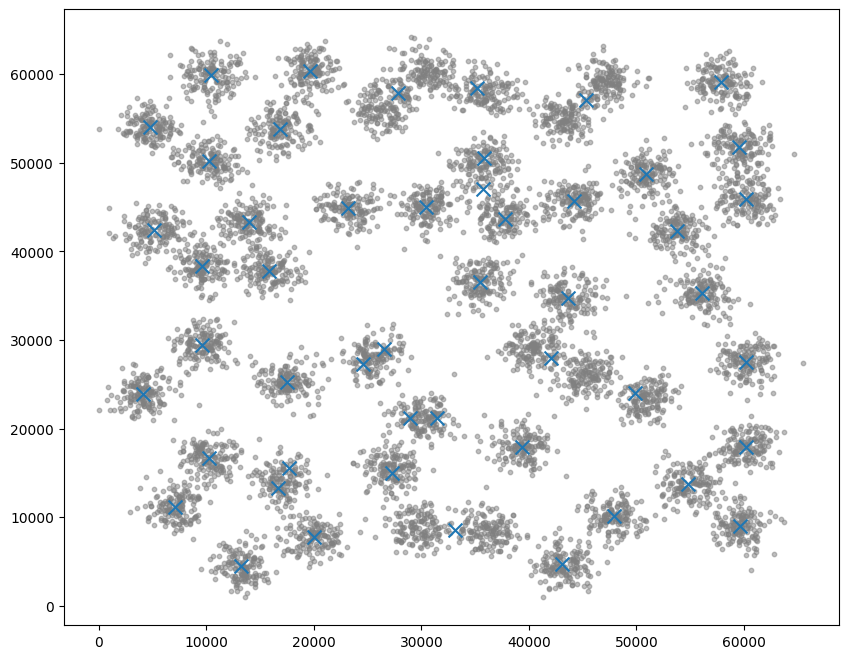

24/12/03 22:22:28 ERROR StandaloneSchedulerBackend: Application has been killed. Reason: Master removed our application: KILLED
24/12/03 22:22:29 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exiting due to error from cluster scheduler: Master removed our application: KILLED
	at org.apache.spark.errors.SparkCoreErrors$.clusterSchedulerError(SparkCoreErrors.scala:291)
	at org.apache.spark.scheduler.TaskSchedulerImpl.error(TaskSchedulerImpl.scala:981)
	at org.apache.spark.scheduler.cluster.StandaloneSchedulerBackend.dead(StandaloneSchedulerBackend.scala:165)
	at org.apache.spark.deploy.client.StandaloneAppClient$ClientEndpoint.markDead(StandaloneAppClient.scala:263)
	at org.apache.spark.deploy.client.StandaloneAppClient$ClientEndpoint$$anonfun$receive$1.applyOrElse(StandaloneAppClient.scala:170)
	at org.apache.spark.rpc.netty.Inbox.$anonfun$process$1(Inbox.scala:115)
	at org.apache.spark.rpc.netty.Inbox.safelyCall(Inbox.scala:213)
	at org.apache.spark.rpc.netty.Inbox.proce

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

plot_data = np.array(parsed_data.collect())

# Plot raw data points
plt.scatter(
    plot_data[:, 0], plot_data[:, 1], 
    s=10, alpha=0.5, label="Raw Data", color='gray'
)

plt.scatter(
    final_group[0][:, 0], final_group[0][:, 1], 
    label=f"Centroids Group", 
    marker='x', s=100
)

In [13]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

data = np.array(parsed_data.collect())
kmeans = KMeans(n_clusters=k, max_iter=max_iterations, random_state=314)
cluster_labels = kmeans.fit_predict(data)

# Evaluate using Silhouette Score
silhouette = silhouette_score(data, cluster_labels)
silhouette

np.float64(0.5730469700246406)

In [14]:
centroid_to_point = parsed_data.map(
    lambda point: (
        np.argmin([np.linalg.norm(point - c) for c in final_centorids]), # cluster_id
        point # original point
    )
).collect()

cluster_labels, data = zip(*centroid_to_point)
silhouette = silhouette_score(data, cluster_labels)
silhouette

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)